In [1]:
%reset -f
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyross

In this notebook we generate synthetic data using the SEAI5R model, and a control protocol consisting of an initial lockdown, which is then partly released.

While we use the Denmark age structure and contact matrix, we emphasise that **the model parameters considered in this notebook have NOT been obtained from real data, but rather are chosen ad-hoc**.

### Load Denmark age structure and contact matrix, coarse grain to four age groups

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

Ni[0] = np.sum(Ni0[0:4])
Ni[1] = np.sum(Ni0[4:8])
Ni[2] = np.sum(Ni0[8:12])
Ni[3] = np.sum(Ni0[12:16])
N=np.sum(Ni)

print(Ni)

[1287864. 1437566. 1556036. 1224130.]


In [4]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.Denmark()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]

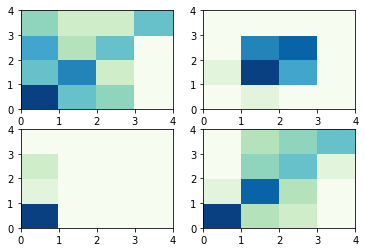

In [5]:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

In [6]:
# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO

### Define model parameters

**Note: These have not been fitted to real data.**

In [7]:
beta  = 0.036692            # infection rate 

gE    = 1/8
gA    = 1/3
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.4                 # fraction of asymptomatic infectives 
# https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
fsa   = 0.2                 # the self-isolation parameter   
fh    = 0
gIh   = 1/7
gIc   = 1/14
 
sa    = 0*np.ones(M)      #  rate of additional/removal of population by birth etc
sa[0]     = 0            # birth
sa[3] = 0          # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
hh[0] = 0.01
hh[1] = 0.05
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC


# initial conditions    
Is_0 = np.zeros((M));  #Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4
 
Ia_0 = 10*np.ones((M)) # start with 10 asymptomatic infectives
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Ih_0 + Ic_0 +Im_0 + R_0)

### Define events for protocol

In [55]:
# Dummy event for initial (standard) contact matrix
events = [lambda t: 1]
contactMatrices = [C]

# Once the population passes above 800, change contact matrix to
#    home + 0.1 * work:
lockdown_threshold_0 = 800
def event0(t,rp):
    return np.sum(rp[4*M:7*M]) - lockdown_threshold_0
event0.direction = +1 # we need to pass the threshold from below for the event
events.append(event0)
contactMatrices.append( CH + 0.1*CW ) # contact matrix = home + 0.1 * work 

# After 100 days of simulation time, change contact matrix to
#    home + 0.1 * work + 0.75 * school
lockdown_threshold_1 = 100
def event1(t,rp):
    return t - lockdown_threshold_1 # np.sum(rp[4*M:7*M]) - lockdown_threshold_1
events.append(event1)
contactMatrices.append( CH + 0.1*CW + 0.5*CS ) # everybody in lockdown

### Initialise pyross.control and run test simulation

In [56]:
# duration of simulation
Tf=150;  Nf=Tf+1;  

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.control.SEAI5R(parameters, M, Ni.copy())


# run model once to check
data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                    events,contactMatrices, Tf, Nf,
                                method='gillespie')

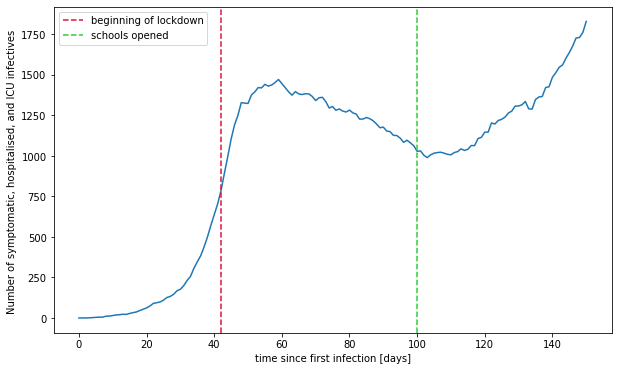

In [57]:
t = data['t']; 

# get total population in classes
# - symptomatic infective,
# - hospitalised,
# - in ICU
y_plot = np.sum ( data['X'][:,4*M:7*M], axis = -1)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(t,y_plot)
ax.axvline(data['events_occured'][0][0],
           color='crimson',
          label='beginning of lockdown',ls='--')
ax.axvline(data['events_occured'][1][0],
 color='limegreen',
          label='schools opened',ls='--')
ax.legend(loc='best')
ax.set_xlabel('time since first infection [days]')
ax.set_ylabel('Number of symptomatic, hospitalised, and ICU infectives ')
plt.show(fig)
plt.close(fig)

### Run 50 simulations with protocol

In [20]:
# Run 50 simulations with this protocol
N_simulations = 50

data_results = np.zeros([N_simulations,Nf,M*9],
                        dtype=int)
lockdown_starts = np.zeros(N_simulations)
for i in range(N_simulations):
    print('Running simulation {0} of {1}'.format(i+1,N_simulations),end='\r')
    data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                    events,contactMatrices, Tf, Nf,
                                method='gillespie')
    data_results[i] = data['X']
    try:
        lockdown_starts[i] = data['events_occured'][0][0]
    except:
        print("no lockdown in simulation {0}".format(i+1))

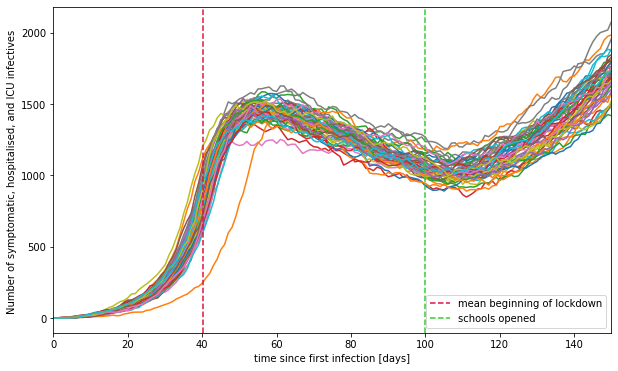

In [42]:
# For all simulations, plot total population in classes
# - symptomatic infective,
# - hospitalised,
# - in ICU


t = data['t']; 
mean_lockdown_start = np.mean(lockdown_starts)
fig,ax = plt.subplots(1,1,figsize=(10,6))
for i,e in enumerate(data_results):
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    ax.plot(t,y_plot)
ax.axvline(mean_lockdown_start,
               color='crimson',
              label='mean beginning of lockdown',ls='--')
ax.axvline(data['events_occured'][1][0],
 color='limegreen',
          label='schools opened',ls='--')
ax.set_xlim(0,Tf)
ax.legend(loc='best')
ax.set_xlabel('time since first infection [days]')
ax.set_ylabel('Number of symptomatic, hospitalised, and ICU infectives ')
plt.show(fig)
plt.close(fig)

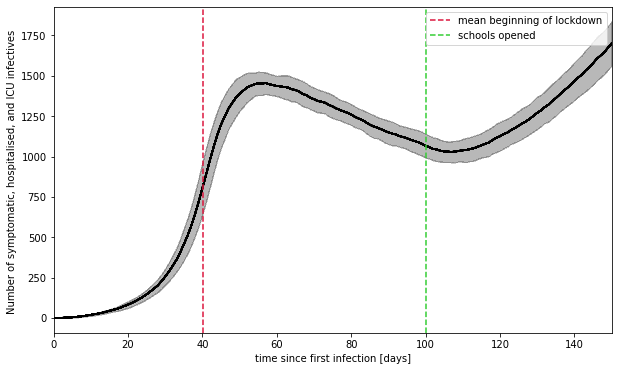

Mean time from beginning of lockdown to subsequent peak = 16.6 days
Mean time from opening of schools to subsequent minimum = 7.8 days


In [44]:
# For all simulations, plot total population in classes
# - symptomatic infective,
# - hospitalised,
# - in ICU

# mean and standard deviation of trajectories at every time
y_mean = np.mean( ( np.sum(data_results[:,:,4*M:7*M], axis = -1) ), axis=0)
y_std = np.std ( np.sum( data_results[:,:,4*M:7*M], axis = -1), axis =0)

t = data['t']; 
mean_lockdown_start = np.mean(lockdown_starts)
fig,ax = plt.subplots(1,1,figsize=(10,6))
for i,e in enumerate(data_results):
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    ax.fill_between(t,y_mean - y_std,y_mean+y_std,
                   color='grey',alpha=0.01)
    ax.plot(t,y_mean,
                   color='black',alpha=1)
ax.axvline(mean_lockdown_start,
               color='crimson',
              label='mean beginning of lockdown',ls='--')
ax.axvline(data['events_occured'][1][0],
 color='limegreen',
          label='schools opened',ls='--')
ax.set_xlim(0,Tf)
ax.legend(loc='best')
ax.set_xlabel('time since first infection [days]')
ax.set_ylabel('Number of symptomatic, hospitalised, and ICU infectives ')
plt.show(fig)
plt.close(fig)

# calculate time from lockdown to local maximum for each trajectory
mask = (t > 30)*(t < 80)
t_mask = t[(mask)]
durations_from_lockdown_to_local_maximum = np.zeros(N_simulations,
                                                   dtype=float)
for i,e in enumerate(data_results):
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    index = np.argmax( y_plot[(mask)])
    durations_from_lockdown_to_local_maximum[i] = t_mask[index] - lockdown_starts[i]
print('Mean time from beginning of lockdown to subsequent peak = {0:3.1f} days'.format(np.mean(durations_from_lockdown_to_local_maximum)))


# calculate time from opening of schools to local minimum for each trajectory
# (recall lockdown_threshold_1 = time at which schools are opened)
mask = (t > lockdown_threshold_1)*(t < Tf)
t_mask = t[(mask)]
durations_from_school_opening_to_local_minimum = np.zeros(N_simulations,
                                                   dtype=float)
for i,e in enumerate(data_results):
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    index = np.argmin( y_plot[(mask)])
    durations_from_school_opening_to_local_minimum[i] = t_mask[index] - lockdown_threshold_1
print('Mean time from opening of schools to subsequent minimum = {0:3.1f} days'.format(np.mean(durations_from_school_opening_to_local_minimum)))

### Plot distributions for both time from beginning of lockdown to subsequent peak, and time from opening of schools to subsequent minimum

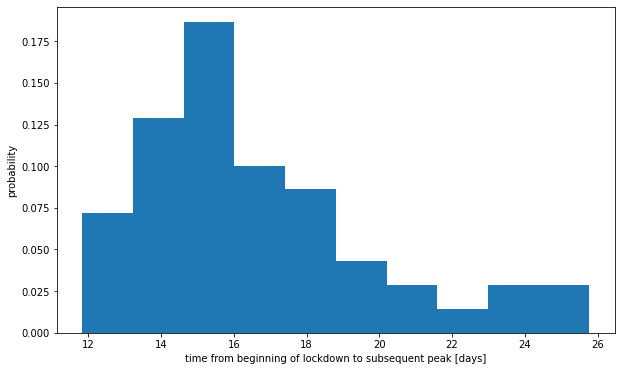

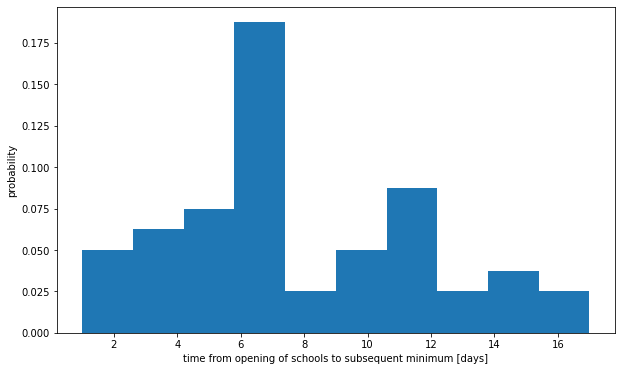

In [51]:
hist, bin_edges = np.histogram(durations_from_lockdown_to_local_maximum,10 ,density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
bin_widths = bin_edges[1]-bin_edges[0]
fig, ax =plt.subplots(1,1,figsize=(10,6))
ax.bar(bin_centers,hist,bin_widths)
ax.set_xlabel('time from beginning of lockdown to subsequent peak [days]')
ax.set_ylabel('probability')
plt.show(fig)
plt.close(fig)



hist, bin_edges = np.histogram(durations_from_school_opening_to_local_minimum,10 ,density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
bin_widths = bin_edges[1]-bin_edges[0]
fig, ax =plt.subplots(1,1,figsize=(10,6))
ax.bar(bin_centers,hist,bin_widths)
ax.set_xlabel('time from opening of schools to subsequent minimum [days]')
ax.set_ylabel('probability')
plt.show(fig)
plt.close(fig)